In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import heapq
from collections import defaultdict, Counter
import struct
import sys

# Funções úteis

In [32]:
def calcEntropy(image):
    hist = cv2.calcHist([image],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()
    return entropy

def divideImageIntoSubImages(image, subImageSize):
    subImages = []
    for i in range(0, image.shape[0], subImageSize):
        for j in range(0, image.shape[1], subImageSize):
            subImages.append(image[i:i+subImageSize, j:j+subImageSize])
    return np.array(subImages)

def reconstructImage(subimages, originalImageShape):
    image = np.zeros(originalImageShape)
    idx = 0
    for i in range(0, originalImageShape[0], subimages[0].shape[0]):
        for j in range(0, originalImageShape[1], subimages[0].shape[1]):
            image[i:i+subimages[0].shape[0], j:j+subimages[0].shape[1]] = subimages[idx]
            idx += 1
    return image

def getNumberOfDifferentColors(img):
    return len(np.unique(img))

def plotImage(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

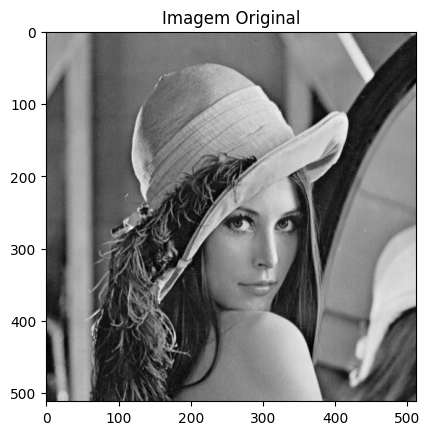

In [33]:
ORIGINAL_IMAGE = cv2.imread('./imagens/lena512.pgm',0)
ORIGINAL_IMAGE_SHAPE = ORIGINAL_IMAGE.shape
plotImage(ORIGINAL_IMAGE, 'Imagem Original')

In [34]:
SUBIMAGES = divideImageIntoSubImages(ORIGINAL_IMAGE, 8)

# Tirar os residuos/  Pegar os resíduos e transformar na imagem original - Giovana 

# Fazer a tranformada/fazer a transformada inversa - Fernando


# Codificar/Decodidicar (huffman) - Araju


In [35]:
class Node:
    def __init__(self, freq, symbol=None, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [Node(freq, symbol) for symbol, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(left.freq + right.freq, left=left, right=right)
        heapq.heappush(heap, merged)

    return heap[0] if heap else None

def generate_huffman_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}

    if node is not None:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        generate_huffman_codes(node.left, prefix + "0", codebook)
        generate_huffman_codes(node.right, prefix + "1", codebook)

    return codebook


# Salvar no arquivo a imagem comprimida/ descomprimir a imagem -  Araju


In [36]:
def encode_data(data, huffman_codes):
    return ''.join(huffman_codes[symbol] for symbol in data)

def decode_data(encoded_data, huffman_codes):
    reverse_huffman_codes = {v: k for k, v in huffman_codes.items()}
    current_code = ""
    decoded_data = []

    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_huffman_codes:
            decoded_data.append(reverse_huffman_codes[current_code])
            current_code = ""

    return decoded_data


def save_to_file(original_image_shape, filename, huffman_codes, encoded_data):
    with open(filename, 'wb') as file:
        file.write(struct.pack('<I', original_image_shape[0]))
        file.write(struct.pack('<I', original_image_shape[1]))
        # Save the number of unique symbols
        file.write(struct.pack('<I', len(huffman_codes)))

        # Save the Huffman codes
        for symbol, code in huffman_codes.items():
            file.write(struct.pack('<i', symbol))  # Symbol as 4 bytes
            file.write(struct.pack('<B', len(code)))  # Length of the code
            file.write(code.encode())  # Code as bytes

        # Save the length of the encoded data in bits
        file.write(struct.pack('<I', len(encoded_data)))

        # Convert the encoded data to bytes
        buffer = 0
        buffer_length = 0
        byte_array = bytearray()

        for bit in encoded_data:
            buffer = (buffer << 1) | int(bit)
            buffer_length += 1

            if buffer_length == 8:
                byte_array.append(buffer)
                buffer = 0
                buffer_length = 0

        if buffer_length > 0:
            buffer <<= (8 - buffer_length)
            byte_array.append(buffer)
        print(sys.getsizeof(byte_array))
        file.write(byte_array)

def load_from_file(filename):
    with open(filename, 'rb') as file:
        # Read the shape of the original image
        original_image_shape = (struct.unpack('<I', file.read(4))[0], struct.unpack('<I', file.read(4))[0])
        # Read the number of unique symbols
        num_symbols = struct.unpack('<I', file.read(4))[0]

        # Read the Huffman codes
        huffman_codes = {}
        for _ in range(num_symbols):
            symbol = struct.unpack('<i', file.read(4))[0]
            code_length = struct.unpack('<B', file.read(1))[0]
            code = file.read(code_length).decode()
            huffman_codes[symbol] = code

        # Read the length of the encoded data in bits
        encoded_data_length = struct.unpack('<I', file.read(4))[0]

        # Read the encoded data as bits
        encoded_data = ''
        while len(encoded_data) < encoded_data_length:
            byte = file.read(1)
            if not byte:
                break
            byte_value = ord(byte)
            encoded_data += f'{byte_value:08b}'

        return original_image_shape, huffman_codes, encoded_data[:encoded_data_length]

def huffman_encode_matrix(matrix):
    flat_list = [item for sublist in matrix for item in sublist]
    frequencies = Counter(flat_list)
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = generate_huffman_codes(huffman_tree)
    encoded_data = encode_data(flat_list, huffman_codes)
    return huffman_codes, encoded_data

def huffman_decode_matrix(encoded_data, huffman_codes, original_shape):
    decoded_flat_list = decode_data(encoded_data, huffman_codes)
    matrix = []
    index = 0
    for row_size in original_shape:
        matrix.append(decoded_flat_list[index:index + row_size])
        index += row_size
    return matrix



In [37]:
# Random Matrix 8 x 8
matrix = [[1, 2, 3, 4, 5, 6, 7, 8],
          [2, 2, 2, 2, 2, 2, 2, 2],
          [3, 4, 5, 6, 7, 8, 9, 10],
          [4, 4, 4, 4, 4, 4, 4, 4],
          [5, 6, 7, 8, 9, 10, 11, 12],
          [6, 6, 6, 6, 6, 6, 6, 6],
          [7, 8, 9, 10, 11, 12, 13, 14],
          [8, 8, 8, 8, 8, 8, 8, 8]]
matrix = np.array(matrix)
original_shape = [len(row) for row in matrix]
huffman_codes, encoded_data = huffman_encode_matrix(matrix)
filename = 'matrix.huff'
save_to_file(matrix.shape, filename, huffman_codes, encoded_data)


loaded_orginal_image_shape, loaded_huffman_codes, loaded_encoded_data = load_from_file(filename)
decoded_matrix = huffman_decode_matrix(loaded_encoded_data, loaded_huffman_codes, original_shape)
print(matrix.shape == np.array(decoded_matrix).shape)
print(decoded_matrix == matrix)

92
True
[[ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]]
